<table>
<tr>
    <td width=10%>
        <img src="images/eisti_logo.png">
    </td>
    <td>
        <center>
            <h1>Deep Learning et Applications</h1>
        </center>
    </td>
    <td width=15%>
        Yann Vernaz 
    </td>
</tr>
</table>

<br/>
<div id="top"></div>
<center>
    <a style="font-size: 20pt; font-weight: bold">Lab. 2.6 - ConvNets Transfert Learning</a>
</center>
<br/>

---

Construire et entraîner son propre `ConvNet` à partir de zéro peut être une tâche longue et coûteuse. De même si on dispose de peu de données on n'arrivera pas à entraîner correctement un modèle `ConvNet`.

Une méthodologie très efficace couramment employée consiste à utiliser un modèle **pré-entraîné** sur un grand ensemble de données et à l'ajuster pour résoudre son problème spécifique.  C'est ce qu'on appelle le _Transfert Learning_.

Si l'ensemble de données original est assez grand et assez général, les caractéristiques (filtres) spatiales apprises par le réseau pré-entraîné peuvent servir de modèle générique pour résoudre notre probème. Par exemple, on peut utiliser un réseau pré-entraîné sur ImageNet (où les classes sont principalement composées d'animaux et d'objets du quotidien), puis réutiliser ce réseau pour classifier des éléments de mobilier dans des images. Cette portabilité des caractéristiques apprises est un avantage clé du Deep Learning par rapport à d'autres approches (analyse d'image classique). 

Il existe deux grandes méthodes de _Transfert Learning_ qui correpondent à deux manières de tirer parti d'un réseau pré-entraîné : 

- **Pur Transfert Learning** - Consiste à extraire des caractérisitques du réseau pré-entraîné, puis les utiliser comme les entrées d'un nouveau réseau (pour traiter une nouvelle tâche de classification). 
- **Fine Tuning Transfert Learning** - Consiste à utiliser le réseau pré-entraîné comme une initialisation des caractérisitiques et à effectuer un (re)apprentissage du réseau (ou réglage précis) sur nos nouvelles données pour résoudre la nouvelle tâche d'imagerie (par exemple une classification).

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import keras
print("Keras ", keras.__version__)

import cleverhans
from keras import models
from keras import layers
from keras import optimizers

Using TensorFlow backend.


('Keras ', '2.2.4')


In [2]:
from keras.preprocessing.image import ImageDataGenerator

base_dir = "GTSRB"
train_dir = os.path.join(base_dir, "Final_Training/Images")
test_dir = os.path.join(base_dir, "Final_Test/Images")

# noms des classes
class_names = ["0000"+str(i) for i in range(10)]+["000"+str(i) for i in range(10,43)]
    


# nombre de classes
nb_class = len(class_names)

train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

batch = 1000

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(100, 100),
                                                    batch_size=batch,
                                                    classes=class_names,
                                                    class_mode="categorical",
                                                    subset = 'training') # set as training data



test_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(100, 100),
                                                    batch_size=batch,
                                                    classes=class_names,
                                                    class_mode="categorical",
                                                    subset = 'validation') # set as validation data


print("\nNombre de données d'entraînement: ", train_generator.n)
print("\nNombre de données d'entraînement: ", test_generator.n)

for data_batch, labels_batch in train_generator:
    print("\nTaille des batchs de données d'entraînement :", data_batch.shape)
    print("Taille des batch des labels d'entraînement:", labels_batch.shape)
    break

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.
("\nNombre de donn\xc3\xa9es d'entra\xc3\xaenement: ", 31368)
("\nNombre de donn\xc3\xa9es d'entra\xc3\xaenement: ", 7841)
("\nTaille des batchs de donn\xc3\xa9es d'entra\xc3\xaenement :", (1000, 100, 100, 3))
("Taille des batch des labels d'entra\xc3\xaenement:", (1000, 43))


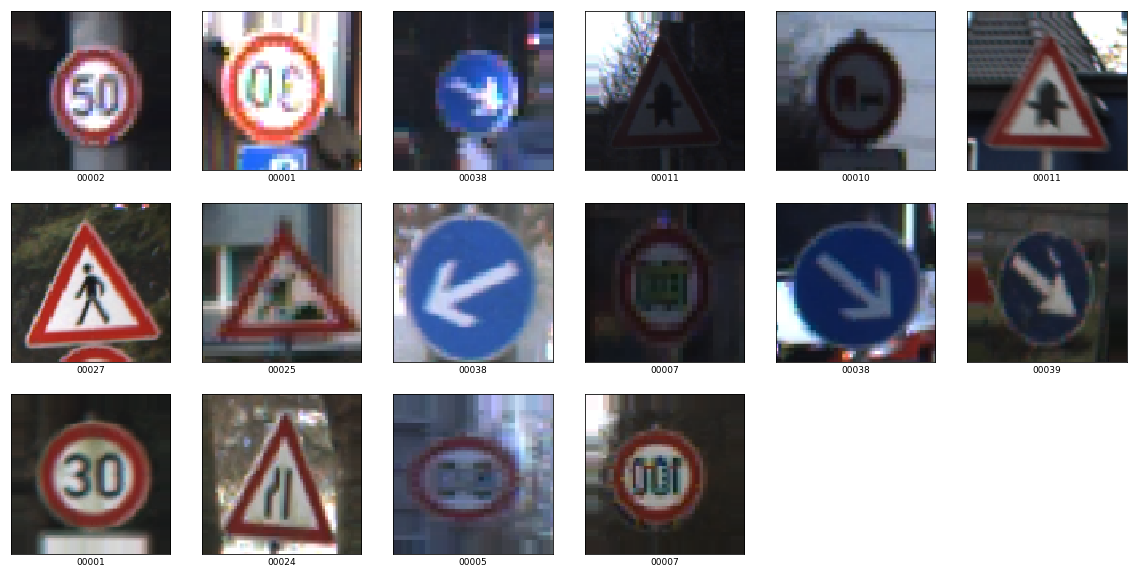

In [3]:
# visualisation des images avec leur label
plt.figure(figsize=(20,10))
for i in range(16):
    plt.subplot(3,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data_batch[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[np.argmax(labels_batch[i])], fontsize=9)

# Pur Transfert Learning

### 1. Pur Transfert Learning avec extraction des caractéristiques

La première méthode de _Transfet Learning_ (la plus simple) consiste à utiliser les représentations apprises par un réseau pré-entraîné (ex. `VGG-16`, `ResNet-50`, ...) pour **extraire des caractéristiques** (_features maps_) sur nos données. Ces caractéristiques sont ensuite utilisées directement par un nouveau classificateur (que l'on doit entraîner pour notre problème de classification avec nos données).

Les réseaux `ConvNets` utilisés pour la classification d’images comportent deux parties : 
- une série de couches de convolution et de _Pooling_, 
- un classificateur qui consiste à des couches entièrement connectées. 

L'extraction de caractéristiques consistera simplement à utiliser ces couches de convolution sur les nouvelles données afin d'extraire des caractéristiques.

<img src="images/swapping_fc_classifier.png" width="60%">

---

> **EXERCICE 3**
>    
> 1. Charger le modèle `VGG-16` pré-entraîné (`Keras` Zoo). Utiliser l'option `include_top=False` pour ne pas inclure les 3 couches entièrement connectées en haut du réseau. Utiliser l'option `input_shape=(100, 100, 3)` pour que le modèle puisse prendre en entrée des images à la bonne dimension.<br/><br/>
> 2. Écrire une fonction `extract_features` qui calcule les représentations à partir du modèle `VGG-16` pour former des _features_. Visualiser quelques _features_ qui sont extraites sur une image.<br/><br/>
> 3. Construire le réseau entièrement connecté suivant pour la classification des images en 6 classes.<br/><br/>
>     Block Dense 1 -  [ Dense(256 neurones) + ReLU ] -> [ Dropout(0.5)]<br/>
>     Block Dense 2 -  [ Dense(512 neurones) + ReLU ] -> [ Dropout(0.5)]<br>
>     Softmax - [ Dense(6 neurones) + Softmax]<br/><br/>
> 4. Entraîner le réseau sur le jeu de données et conclure.

---

In [4]:
from keras.applications.vgg16 import VGG16

model_base = VGG16(include_top=False , weights="imagenet", input_shape=(100, 100, 3))
model_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

### 2. Pur Transfert Learning avec augmentation des données

Passons maintenant à la deuxième technique, beaucoup plus lente et plus coûteuse, mais qui nous permet de tirer parti de l'augmentation des données au cours de l'entraînement : extension du modèle `VGG-16` et exécution de bout en bout sur les entrées. 

Notez que cette technique est en fait si coûteuse que vous ne devriez l’essayer que si vous avez accès à un GPU ... sinon ce sera très très long sur un CPU. Si vous ne pouvez pas exécuter votre code sur un GPU, la technique précédente est la voie à suivre.

Comme les modèles se comportent exactement comme des briques (ou _lego_), vous pouvez ajouter un modèle (comme `VGG-16`) à un autre modèle séquentiel.

---

> **EXERCICE 4**
>    
> 1. Construire un modèle sequentiel `Keras` qui va concaténer le modèle  `model_base_` (`VGG-16`) avec notre modèle de classification.<br/><br/>
> 
> 2. "Geler" les paramètres/poids des couches qui correspondents au modèle de base (`VGG-16`). Entraîner le réseau sur le jeu de données en utilisant une augmentation des données avec la fonction [ImageDataGenerator](https://keras.io/preprocessing/image/).<br/><br/> 
>
> 3. Conclure.

---

In [5]:
# VGG-16 (pre-trained) + notre réseau classification layers
model_pur_transfert = models.Sequential()

model_pur_transfert.add(model_base)
model_pur_transfert.add(layers.Flatten())
model_pur_transfert.add(layers.Dense(units=256, activation="relu", name="Dense_1"))
model_pur_transfert.add(layers.Dropout(rate=0.5, name="Dropout_Dense_1"))

model_pur_transfert.add(layers.Dense(units=512, activation="relu", name="Dense_2"))
model_pur_transfert.add(layers.Dropout(rate=0.5, name="Dropout_Dense_2"))

model_pur_transfert.add(layers.Dense(units=43, activation="softmax", name="Softmax"))

model_pur_transfert.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model_pur_transfert.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
Dense_1 (Dense)              (None, 256)               1179904   
_________________________________________________________________
Dropout_Dense_1 (Dropout)    (None, 256)               0         
_________________________________________________________________
Dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
Dropout_Dense_2 (Dropout)    (None, 512)               0         
_________________________________________________________________
Softmax (Dense)              (None, 43)                22059     
Total para

In [6]:
print("Nombre de paramètre du modèle de base (couches de convolution de VGG-16):", model_base.count_params())
print("Nombre de paramètre du classifieur:", model_pur_transfert.count_params()-model_base.count_params())

('Nombre de param\xc3\xa8tre du mod\xc3\xa8le de base (couches de convolution de VGG-16):', 14714688)
('Nombre de param\xc3\xa8tre du classifieur:', 1333547)


Avant de compiler et d’entraîner notre modèle, il est très important de geler la base de convolution. "Geler" une couche ou un ensemble de couches signifie que leurs poids ne sont pas mis à jour pendant l'entraînement. 

Si nous ne le faisons pas, alors les représentations qui étaient précédemment apprises par `VGG-16` serait modifié au cours de la formation. Etant donné que les couches `Dense` sont initialisées de manière aléatoire, des mises à jour de très grand poids seraient propagées à travers le réseau, détruisant ainsi les représentations précédemment apprises.

Dans `Keras`, le gel d'un réseau est effectué en définissant son attribut` trainable` sur `False`.

In [7]:
print("Nombre de couches pouvant être entraînés:", len(model_pur_transfert.trainable_weights))

('Nombre de couches pouvant \xc3\xaatre entra\xc3\xaen\xc3\xa9s:', 32)


In [8]:
for layer in model_base.layers:
    layer.trainable = False

In [9]:
print("Nombre de couches pouvant être entraînés"
      " (après le gel des couches du modèle de base):", len(model_pur_transfert.trainable_weights))

('Nombre de couches pouvant \xc3\xaatre entra\xc3\xaen\xc3\xa9s (apr\xc3\xa8s le gel des couches du mod\xc3\xa8le de base):', 6)


Avec cette configuration, seuls les poids des trois couches `Dense` que nous avons ajoutées seront entraînés. Notez que pour que ces modifications prennent effet, nous devons d’abord compiler le modèle.

In [10]:
model_pur_transfert.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model_pur_transfert.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
Dense_1 (Dense)              (None, 256)               1179904   
_________________________________________________________________
Dropout_Dense_1 (Dropout)    (None, 256)               0         
_________________________________________________________________
Dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
Dropout_Dense_2 (Dropout)    (None, 512)               0         
_________________________________________________________________
Softmax (Dense)              (None, 43)                22059     
Total para

Augmentation des données avec la fonction [ImageDataGenerator](https://keras.io/preprocessing/image/).

In [ ]:
model_pur_transfert.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

#pur_transfert_history = model_pur_transfert.fit_generator(train_generator,
#                                                          steps_per_epoch=20,
#                                                          epochs=30,
#                                                          validation_data=test_generator,
#                                                          validation_steps=20,
#                                                          workers=4, use_multiprocessing=True, verbose=2)



pur_transfert_history = model_pur_transfert.fit_generator(
                                                            train_generator,
                                                            steps_per_epoch = batch,
                                                            validation_data = test_generator, 
                                                            validation_steps = batch,
                                                            epochs = 30,
                                                            workers=4, use_multiprocessing=True, verbose=1)




/home/goupilfran/anaconda3/envs/tensorflow_env/lib/python2.7/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/30


In [ ]:
plot_learning_curves(pur_transfert_history)

In [ ]:
model_pur_transfert.model.save("model_pur_transfert_car.h5")

# Fine Tuning Transfert Learning

Une autre technique largement utilisée, complémentaire à l'extraction de caractéristiques, est le «réglage fin» (_fine tuning_). Le réglage fin consiste à dégeler quelques-unes des couches supérieures du modèle de base et à entraîner conjointement la partie nouvellement ajoutée (dans notre cas, le classificateur entièrement connecté). C'est ce que l'on appelle _fine tuning_, car cela ajuste légèrement les représentations les plus abstraites du modèle pré-entraîné afin de les rendre plus pertinentes pour notre problème spécifique.

---

> **EXERCICE 5**
>    
> 1. Libérer les 3 dernières couches convolutives du réseau de base, ce qui signifie que toutes les couches jusqu’à `block4_pool` doivent être gelées et que les couches `block5_conv1`, `block5_conv2` et `block5_conv3` doivent pouvoir être entraînées.<br/><br/>
>
> 2. Entraîner le modèle avec l'optimiseur `RMSprop` et en utilisant un taux d'apprentissage très petit (1e-5). L’utilisation d’un taux d’apprentissage faible s’explique par le fait que nous voulons limiter l’ampleur des modifications que nous apportons aux représentations des 3 couches que nous ajustons. Des mises à jour trop grandes peuvent nuire à ces représentations.<br/><br/> 
>
> 3. Conclure.

---

#### Remarques

Pourquoi ne pas afiner davantage de couches ? Pourquoi ne pas affiner toutes les couches de convolution ? 

Nous pourrions, cependant, nous devons considérer que :

* Les premières couches de convolution codent des caractéristiques génériques et réutilisables, tandis que les couches supérieures codent des caractéristiques de plus en plus spécialisées. Il est donc plus utile d'affiner les couches les plus spécialisées, car ce sont celles qui doivent être adaptées à notre nouveau problème.<br/><br/>

* Plus nous entraînons de paramètres, plus nous risquons un sur-ajustement. Les couches de convolution ont ~ 15 millions de paramètres, donc il est risqué d'essayer de l'entraîner sur notre petit jeu de données.

Ainsi, dans notre situation, il est judicieux de ne régler finement que les 2 à 3 dernières couches de convolution.

In [ ]:
model_fine_tuning = models.Sequential()

model_fine_tuning.add(model_base)
model_fine_tuning.add(layers.Flatten())
model_fine_tuning.add(layers.Dense(units=256, activation="relu", name="Dense_1"))
model_fine_tuning.add(layers.Dropout(rate=0.5, name="Dropout_Dense_1"))

model_fine_tuning.add(layers.Dense(units=512, activation="relu", name="Dense_2"))
model_fine_tuning.add(layers.Dropout(rate=0.5, name="Dropout_Dense_2"))

model_fine_tuning.add(layers.Dense(units=6, activation="softmax", name="Softmax"))

model_fine_tuning.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model_fine_tuning.summary()

On peut voir que tous les paramètres du modèle sont entraînables, c'est-à-dire 16 029 254 ...

Nous allons geler toutes les couches de convolution du modèle `VGG-16` jusqu'à la couche `block5_conv1`.

In [ ]:
model_base.trainable = True
set_trainable = False

# liste des couches du modèle VGG-16 que l'on doit (re)entraîner
layer_to_learn = ["block5_conv1", "block5_conv2", "block5_conv3"]

for layer in model_base.layers:
    if layer.name in layer_to_learn:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model_base.compile(optimizer=optimizers.RMSprop(lr=1e-5), 
                   loss="categorical_crossentropy", 
                   metrics=["accuracy"])
model_fine_tuning.compile(optimizer=optimizers.RMSprop(lr=1e-5), 
                          loss="categorical_crossentropy",
                          metrics=["accuracy"])

model_fine_tuning.summary()

On peut voir que à présent on peut entraîner 8 393 990 paramètres.

In [ ]:
fine_tuning_history = model_fine_tuning.fit_generator(train_generator, 
                                                      steps_per_epoch=20, 
                                                      epochs=30,
                                                      validation_data=test_generator,
                                                      validation_steps=20, 
                                                      workers=4, use_multiprocessing=True, verbose=2)

In [ ]:
plot_learning_curves(fine_tuning_history)

In [ ]:
model_fine_tuning.save("model_fine_tuning_car.h5")

# Takeaways

Les `ConvNets` sont (aujourd'hui) les meilleurs modèles d’apprentissage automatique pour les tâches de vision par ordinateur. Il est possible d'entraîner un modèle à partir de rien, même sur un très petit ensemble de données, avec des résultats décents. Sur un petit jeu de données le problème principal sera le surajustement (_overfitting_). L'augmentation des données peut-être un moyen de lutter contre le surajustement. Nous étudierons  d'autres méthodes de régularisation lors du prochain TP.

Il est facile de réutiliser un `ConvNet` existant sur un nouveau jeu de données, via le _Transfert Learning_. Les meilleures performances sont obtenues en utilisant la méthode dite de _fine tuning_ qui permet un réglace précis des paramètres.

Vous disposez maintenant d'un ensemble d'outils performant pour traiter les problèmes de classification des images, même sur des petits jeux de données.